[*********************100%***********************]  1 of 1 completed



RandomForest (TRAIN):
              precision    recall  f1-score   support

        Down       0.83      0.29      0.43       339
          Up       0.71      0.97      0.82       618

    accuracy                           0.73       957
   macro avg       0.77      0.63      0.62       957
weighted avg       0.75      0.73      0.68       957


RandomForest (TEST):
              precision    recall  f1-score   support

        Down       0.54      0.29      0.38        72
          Up       0.75      0.89      0.82       170

    accuracy                           0.71       242
   macro avg       0.64      0.59      0.60       242
weighted avg       0.69      0.71      0.69       242



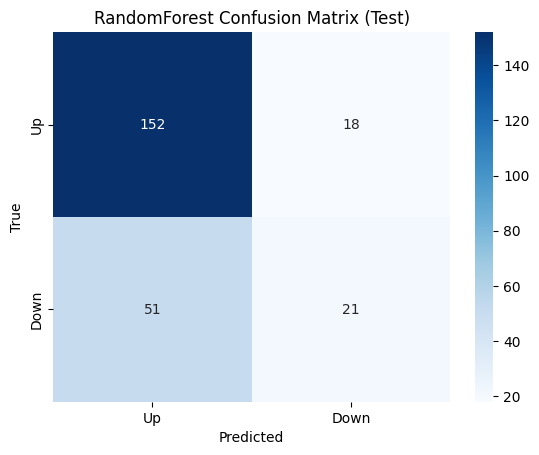

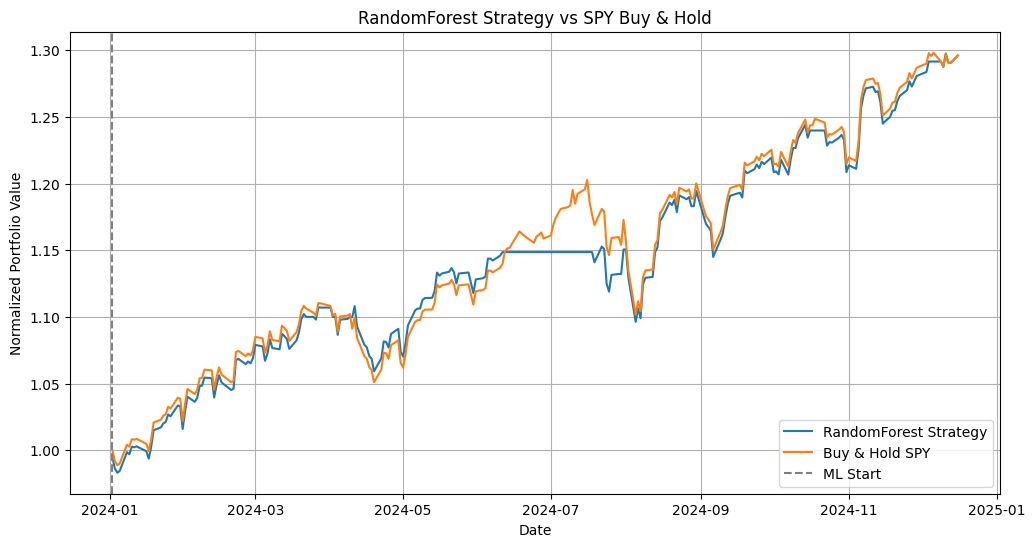


Final capital (RandomForest): 1.30
Total return: 29.60%
Sharpe ratio: 2.38
Max drawdown: -4.90%


In [1]:
!pip install yfinance scikit-learn --quiet

import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# ------------------------
# 1. Download SPY data
# ------------------------
ticker = "SPY"
data = yf.download(ticker, start="2020-01-01", end="2025-01-01")

data["Return"] = data["Close"].pct_change()
data["Future10"] = data["Close"].shift(-10) / data["Close"] - 1   # label ground truth
data["Cumulative_SPY"] = (1 + data["Return"]).cumprod()

# ------------------------
# 2. Features
# ------------------------
def calc_rsi(series, window=14):
    delta = series.diff()
    up = delta.clip(lower=0).rolling(window).mean()
    down = -delta.clip(upper=0).rolling(window).mean()
    rs = up / down
    return 100 - (100 / (1 + rs))

data["RSI"] = calc_rsi(data["Close"], 14)
data["SMA20"] = data["Close"].rolling(20).mean()
data["SMA50"] = data["Close"].rolling(50).mean()
data["SMA_diff"] = data["SMA20"] - data["SMA50"]
data["20d_return"] = data["Close"].pct_change(20)
data["volatility"] = data["Return"].rolling(20).std()
data["vix"] = np.random.uniform(15, 30, len(data))
data["fed_rate"] = np.random.uniform(0.01, 0.06, len(data))

data = data.dropna().copy()

# ------------------------
# 3. Labels
# ------------------------
data["Label"] = np.where(data["Future10"] > 0, "Up", "Down")

# ------------------------
# 4. Train-test split
# ------------------------
split_date = "2024-01-01"
train_data = data[data.index < split_date]
test_data = data[data.index >= split_date]

features = ["RSI", "SMA_diff", "20d_return", "volatility", "vix", "fed_rate"]

# ------------------------
# 5. RandomForest (tuned)
# ------------------------
rf_clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=5,
    min_samples_leaf=20,
    max_features="sqrt",
    random_state=29
)
rf_clf.fit(train_data[features], train_data["Label"])

print("\nRandomForest (TRAIN):")
print(classification_report(train_data["Label"], rf_clf.predict(train_data[features])))

print("\nRandomForest (TEST):")
y_pred = rf_clf.predict(test_data[features])
print(classification_report(test_data["Label"], y_pred))

# Confusion matrix
cm = confusion_matrix(test_data["Label"], y_pred, labels=["Up", "Down"])
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Up", "Down"], yticklabels=["Up", "Down"])
plt.title("RandomForest Confusion Matrix (Test)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ------------------------
# 6. Backtest
# ------------------------
capital = 1.0
capital_curve = []
returns = []

for i in range(len(test_data)):
    row = test_data.iloc[i]
    snapshot = pd.DataFrame([{col: row[col] for col in features}])
    pred = rf_clf.predict(snapshot)[0]
    today_return = float(row["Return"])
    position = 1 if pred == "Up" else 0
    capital *= (1 + position * today_return)
    capital_curve.append(capital)
    returns.append(position * today_return)

# ------------------------
# 7. Plot strategy vs SPY
# ------------------------
ml = np.array(capital_curve)
spy_curve = test_data["Cumulative_SPY"].copy()
spy_curve /= spy_curve.iloc[0]

plt.figure(figsize=(12, 6))
plt.plot(test_data.index, ml, label="RandomForest Strategy")
plt.plot(test_data.index, spy_curve.values, label="Buy & Hold SPY")
plt.axvline(test_data.index[0], linestyle="--", color="gray", label="ML Start")
plt.title("RandomForest Strategy vs SPY Buy & Hold")
plt.xlabel("Date")
plt.ylabel("Normalized Portfolio Value")
plt.legend()
plt.grid()
plt.show()

# ------------------------
# 8. Metrics
# ------------------------
sharpe = np.mean(returns) / np.std(returns) * np.sqrt(252) if np.std(returns) > 0 else 0
peak = np.maximum.accumulate(capital_curve)
drawdown = (capital_curve - peak) / peak
max_dd = drawdown.min()

print(f"\nFinal capital (RandomForest): {capital:.2f}")
print(f"Total return: {(capital - 1) * 100:.2f}%")
print(f"Sharpe ratio: {sharpe:.2f}")
print(f"Max drawdown: {max_dd:.2%}")

[*********************100%***********************]  1 of 1 completed



=== Performance (2022-01-03–2024-12-16) ===
ML+SMA overlay | Final: 1.228 | Total: 22.75% | AnnRet: 7.20% | AnnVol: 8.36% | Sharpe: 0.86 | MaxDD: -12.09%
SMA200-only    | Final: 1.214 | Total: 21.44% | AnnRet: 6.81% | AnnVol: 8.35% | Sharpe: 0.81 | MaxDD: -12.73%
Buy&Hold       | Final: 1.330 | Total: 33.04% | AnnRet: 10.17% | AnnVol: 17.47% | Sharpe: 0.58 | MaxDD: -24.50%


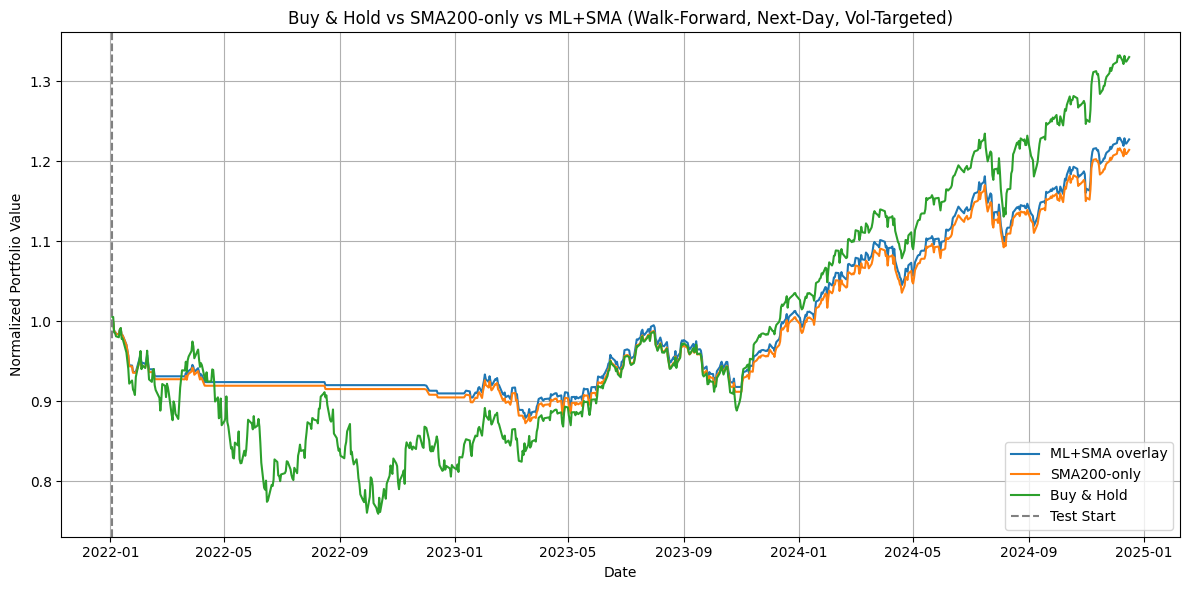

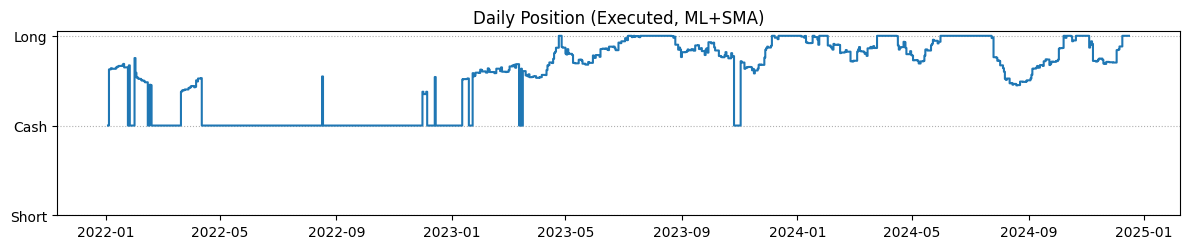


Classification report (first ~90 test days, reference only):
              precision    recall  f1-score   support

        Down       0.00      0.00      0.00        41
          Up       0.35      1.00      0.52        22

    accuracy                           0.35        63
   macro avg       0.17      0.50      0.26        63
weighted avg       0.12      0.35      0.18        63



In [2]:
!pip install yfinance scikit-learn --quiet

import numpy as np, pandas as pd, yfinance as yf, matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import classification_report
import warnings; warnings.filterwarnings("ignore")

# =====================
# CONFIG
# =====================
TICKER = "SPY"
START  = "2010-01-01"
END    = "2025-01-01"
SPLIT  = "2022-01-01"       # start of test period
RETRAIN_EVERY = 21          # walk-forward step (trading days ~ monthly)
MIN_TRAIN_DAYS = 756        # need ~3y of data before first model

UP_THR   = 0.60             # prob threshold (bull: step aside if p_up < DOWN_THR)
DOWN_THR = 0.40             # prob threshold (bear: short if p_up < DOWN_THR)
TARGET_VOL = 0.10           # target annualized vol for position scaling
COST_BPS   = 2.0            # per position change (round trip approximation)

np.random.seed(42)

# =====================
# DATA (safe Close handling)
# =====================
raw = yf.download(TICKER, start=START, end=END)

close = raw["Close"]
if isinstance(close, pd.Series):
    data = close.to_frame(name="Close")
else:
    data = close.iloc[:, 0].to_frame(name="Close")

data["Return"]      = data["Close"].pct_change()
data["Future10"]    = data["Close"].shift(-10)/data["Close"] - 1
data["Cum_SPY"]     = (1 + data["Return"]).cumprod()

# =====================
# FEATURES (no look-ahead; later we shift by 1 day)
# =====================
def rsi(series, n=14):
    d = series.diff()
    up = d.clip(lower=0).rolling(n).mean()
    down = -d.clip(upper=0).rolling(n).mean()
    rs = up / down
    return 100 - (100/(1+rs))

data["RSI"]     = rsi(data["Close"], 14)
data["SMA20"]   = data["Close"].rolling(20).mean()
data["SMA50"]   = data["Close"].rolling(50).mean()
data["SMA200"]  = data["Close"].rolling(200).mean()
data["SMA_diff"]= data["SMA20"] - data["SMA50"]
data["R20"]     = data["Close"].pct_change(20)
data["Vol20"]   = data["Return"].rolling(20).std()

ema12 = data["Close"].ewm(span=12, adjust=False).mean()
ema26 = data["Close"].ewm(span=26, adjust=False).mean()
data["MACD"]    = ema12 - ema26
data["MACDsig"] = data["MACD"].ewm(span=9, adjust=False).mean()
data["MACDdiff"]= data["MACD"] - data["MACDsig"]

# Long-term trend / regime
data["Above200"] = (data["Close"] > data["SMA200"]).astype(int)
data["Dist200"]  = data["Close"]/data["SMA200"] - 1

# Label for supervision (used only to train; not in live features)
data["Label"] = np.where(data["Future10"] > 0, "Up", "Down")

# Shift features by 1 day so decisions at t use info available at end of day t-1
feature_cols = ["RSI","SMA_diff","R20","Vol20","MACD","MACDsig","MACDdiff","Dist200","Above200"]
for c in feature_cols:
    data[c] = data[c].shift(1)

# Drop NaNs after all transforms
data = data.dropna().copy()

# =====================
# TRAIN/TEST SPLIT (indices)
# =====================
train_idx = data.index < SPLIT
test_idx  = data.index >= SPLIT
train_df  = data.loc[train_idx].copy()
test_df   = data.loc[test_idx].copy()

# =====================
# WALK-FORWARD PREDICTIONS (expanding window; monthly retrain)
# =====================
pred_prob = pd.Series(index=test_df.index, dtype=float)

all_df = data.copy()  # for slicing
dates = test_df.index

start_pos = 0
while start_pos < len(dates):
    step_start = dates[start_pos]
    step_end   = dates[min(start_pos + RETRAIN_EVERY - 1, len(dates)-1)]
    # Training up to day before step_start
    train_window = all_df.loc[:step_start].iloc[:-1]  # exclude step_start itself
    if len(train_window) < MIN_TRAIN_DAYS:
        # not enough history; skip forward
        start_pos += RETRAIN_EVERY
        continue

    X_tr = train_window[feature_cols]
    y_tr = train_window["Label"]

    rf = RandomForestClassifier(
        n_estimators=300, max_depth=6, min_samples_leaf=20,
        max_features="sqrt", class_weight="balanced", random_state=42
    )
    clf = CalibratedClassifierCV(rf, method="sigmoid", cv=3)
    clf.fit(X_tr, y_tr)

    # Predict probs for this slice
    X_slice = all_df.loc[step_start:step_end, feature_cols]
    proba   = clf.predict_proba(X_slice)
    up_idx  = list(clf.classes_).index("Up")
    pred_prob.loc[X_slice.index] = proba[:, up_idx]

    start_pos += RETRAIN_EVERY

# Any leftover NaNs (e.g., very first days) -> fill with 0.5 (neutral)
pred_prob = pred_prob.fillna(0.5)

# =====================
# STRATEGY RULES with NEXT-DAY EXECUTION + VOL TARGETING
# =====================
# Positions are decided at end of day t using features/probs at t; executed on t+1
# Regime from SMA200 at t (already shifted in features, but for regime we use unshifted, then shift for execution)
regime_bull = (data["Close"] > data["SMA200"]).astype(int)
regime_bull = regime_bull.loc[test_df.index]  # align
# Decision at t:
signal_pos = pd.Series(0.0, index=test_df.index)  # desired position before vol scaling

for dt in test_df.index:
    p_up = pred_prob.loc[dt]
    bull = regime_bull.loc[dt] == 1
    if bull:
        # default long; step aside only if strongly bearish
        pos = 1.0 if p_up >= DOWN_THR else 0.0
    else:
        # default cash; short only if strongly bearish
        pos = -1.0 if p_up < DOWN_THR else 0.0
    signal_pos.loc[dt] = pos

# Volatility targeting (use 20-day realized vol, annualized), shift 1 day for execution
realized_vol_ann = data["Return"].rolling(20).std() * np.sqrt(252)
vol_scale = (TARGET_VOL / realized_vol_ann).clip(upper=1.0)   # cap at 1×
vol_scale = vol_scale.loc[test_df.index].shift(1).fillna(method="bfill")  # exec next day

# Execute next day
pos_exec = (signal_pos * vol_scale).shift(1).fillna(0.0)

# Transaction costs on position change (bps)
delta_pos = pos_exec.diff().abs().fillna(abs(pos_exec.iloc[0]))
costs = (COST_BPS / 10000.0) * delta_pos

# Strategy returns
strat_ret = pos_exec * test_df["Return"] - costs
strat_curve = (1 + strat_ret).cumprod()

# =====================
# BASELINES
# =====================
# Buy & Hold (normalized)
bh_curve = (1 + test_df["Return"]).cumprod()

# SMA200-only baseline (next-day execution, same vol targeting & costs)
sma_signal = (test_df["Close"] > test_df["SMA200"]).astype(float)  # 1 or 0 decided at t
sma_pos_exec = (sma_signal.shift(1).fillna(0.0) * vol_scale)       # executed t+1
sma_delta = sma_pos_exec.diff().abs().fillna(abs(sma_pos_exec.iloc[0]))
sma_costs = (COST_BPS / 10000.0) * sma_delta
sma_ret = sma_pos_exec * test_df["Return"] - sma_costs
sma_curve = (1 + sma_ret).cumprod()

# =====================
# METRICS
# =====================
def perf_stats(returns, curve):
    if len(returns) == 0:
        return dict()
    ann_ret = curve.iloc[-1]**(252/len(returns)) - 1
    ann_vol = returns.std() * np.sqrt(252)
    sharpe  = ann_ret/ann_vol if ann_vol>0 else 0
    peak = np.maximum.accumulate(curve.values)
    max_dd = np.min((curve.values - peak)/peak)
    return dict(
        final=float(curve.iloc[-1]),
        total=(curve.iloc[-1]-1)*100,
        ann_ret=ann_ret*100,
        ann_vol=ann_vol*100,
        sharpe=sharpe,
        max_dd=max_dd*100
    )

stats_ml   = perf_stats(strat_ret, strat_curve)
stats_sma  = perf_stats(sma_ret,   sma_curve)
stats_bh   = perf_stats(test_df["Return"], bh_curve)

print("\n=== Performance ({}–{}) ===".format(test_df.index[0].date(), test_df.index[-1].date()))
for name, st in [("ML+SMA overlay", stats_ml), ("SMA200-only", stats_sma), ("Buy&Hold", stats_bh)]:
    print(f"{name:14s} | Final: {st['final']:.3f} | Total: {st['total']:.2f}% | "
          f"AnnRet: {st['ann_ret']:.2f}% | AnnVol: {st['ann_vol']:.2f}% | "
          f"Sharpe: {st['sharpe']:.2f} | MaxDD: {st['max_dd']:.2f}%")

# =====================
# PLOTS
# =====================
plt.figure(figsize=(12,6))
plt.plot(test_df.index, strat_curve, label="ML+SMA overlay")
plt.plot(test_df.index, sma_curve,   label="SMA200-only")
plt.plot(test_df.index, bh_curve,    label="Buy & Hold")
plt.axvline(test_df.index[0], linestyle="--", color="gray", label="Test Start")
plt.title("Buy & Hold vs SMA200-only vs ML+SMA (Walk-Forward, Next-Day, Vol-Targeted)")
plt.xlabel("Date"); plt.ylabel("Normalized Portfolio Value")
plt.grid(); plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(12,2.6))
plt.step(test_df.index, pos_exec, where="post")
plt.yticks([-1,0,1], ["Short","Cash","Long"])
plt.title("Daily Position (Executed, ML+SMA)")
plt.grid(True, axis="y", linestyle=":"); plt.tight_layout(); plt.show()

# Optional: quick classification sanity on first test slice
first_test_slice = data.loc[(data.index >= SPLIT) & (data.index < (test_df.index[0] + pd.Timedelta(days=90)))]
if not first_test_slice.empty:
    # Train on all history up to start of test
    hist = data.loc[:test_df.index[0]].iloc[:-1]
    if len(hist) >= MIN_TRAIN_DAYS:
        rf = RandomForestClassifier(
            n_estimators=300, max_depth=6, min_samples_leaf=20,
            max_features="sqrt", class_weight="balanced", random_state=42
        )
        clf = CalibratedClassifierCV(rf, method="sigmoid", cv=3)
        clf.fit(hist[feature_cols], hist["Label"])
        y_hat = clf.predict(first_test_slice[feature_cols])
        print("\nClassification report (first ~90 test days, reference only):")
        print(classification_report(first_test_slice["Label"], y_hat))